# 1. Data set Load

In [157]:
import pandas as pd
import numpy as np

# 함수 파일 import
import import_ipynb
from function_file import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [158]:
train=pd.read_csv(r"C:\Users\USER\Desktop\프로그래밍 공부\캐글 모델링\boston house\data\train.csv", index_col='Id')
test=pd.read_csv(r"C:\Users\USER\Desktop\프로그래밍 공부\캐글 모델링\boston house\data\test.csv", index_col='Id')

# 2. 타겟변수 정규화

In [159]:
train['SalePrice'] = np.log1p(train["SalePrice"])

In [160]:
# train set과 test set을 병합해서 결측값 처리
data=pd.concat([train,test], sort=False)

# 3. 결측값 처리

In [161]:
missing_col=list(data.columns[data.isnull().any()])
missing_sorted=data[missing_col].isnull().sum().sort_values(ascending=False)

#결측치가 '없음'을 의미하는 특성들의 결측치는 'nan'으로 채움
non_col=[
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish",
    "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"
]
for i in non_col:
    data[i]=data[i].fillna('nan')

for i in non_col:
     missing_col.remove(i)
     
mode_list=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Electrical', 
                'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 
                'GarageCars', 'SaleType']
for i in mode_list:
    data[i] = data[i].fillna(data[i].mode().iloc[0])
    
mean_list=['TotalBsmtSF','GarageArea']
for i in mean_list:
    data[i] = data[i].fillna(data[i].mean())
    
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(0)

In [162]:
# 결측값있는 특성
missing_col=list(data.columns[data.isnull().any()])
missing_sorted=data[missing_col].isnull().sum().sort_values(ascending=False)
print(missing_col)
print(int(missing_sorted))

['SalePrice']
1459


# 4. 파생변수

In [163]:
# 용도 구역 분류 중 주거용 밀집, 저밀도...를 주거용으로 합침
# data['MSZoning'].replace(['RH','RL','RP','RM'],['R','R','R','R'], inplace=True)

# 집 전체 피트
data['TotalFlrSF']= (data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF'])

# 현관 전체 피트
data['Totalporchsf'] = (data['OpenPorchSF'] 
                              + data['3SsnPorch'] 
                              + data['EnclosedPorch'] 
                              + data['ScreenPorch'] 
                              + data['WoodDeckSF'])

# 집의 내외부 점수를 합친 column overall생성
data['Overall']=data['OverallQual']+data['OverallCond']

# 전체 화장실 개수 (지하실 포함)
data['TotalBath'] = (data['FullBath'] + (data['HalfBath']/2) + data['BsmtFullBath'] + (data['BsmtHalfBath']/2))

# # 외부 재료 품질 평가 + 현재 상태 평가
# data['Exter']=data['ExterQual']+data['ExterCond']

# 리모델링 여부
data['RemodorNot'] = np.where(data['YearBuilt'] == data['YearRemodAdd'], 0, 1) 

# 지하실 여부
data['BsmtorNot'] = data['BsmtQual'].apply(lambda x: 0 if x == 'nan' else 1)

# 벽난로 여부
data['FireplaceorNot'] = np.where(data['Fireplaces'] > 0, 'no', 'yes')

# 수영장 여부
data['PoolorNot'] = np.where(data['PoolArea'] > 0, 1, 0)

# 차고 여부
data['GarageorNot'] = np.where(data['GarageArea'] > 0, 1, 0) # 차고 여부
 
# 울타리 여부
data['FenceorNot'] = data['Fence'].apply(lambda x: 0 if x == 'nan' else 1)

#2층 여부
data['2ndflrorNot'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# 현관 여부
data['PorchorNot']=np.where(data['Totalporchsf'] > 0, 1, 0)  # 추가
                            
zero_list =['WoodDeckSF', 'MasVnrArea', 'LowQualFinSF', 'MiscVal'] # 추가
for i in zero_list:
    data[f'{i}orNot'] = np.where(data[i] > 0, 1, 0)
    print(f'{i}orNot')

WoodDeckSForNot
MasVnrAreaorNot
LowQualFinSForNot
MiscValorNot


### * 연도를 10단위로 묶음 -> 순서형으로 봄

In [164]:
from sklearn.preprocessing import LabelEncoder
year_feature=['YearRemodAdd','GarageYrBlt','YearBuilt']

# 10년 단위로 묶음
for i in year_feature:
    data[i]=(data[i]//10)*10
    
# 10년 단위로 묶은 후 라벨인코딩
label_encoder = LabelEncoder()
for i in year_feature:
    data[i] = label_encoder.fit_transform(data[i])

# 4. 순서형 명목형 연속형 구분

order_data.ipynb에서 분류한 순서, 연속, 카테고리형 리스트 pickle로 불러옴

In [165]:
import pickle

# 순서 적용해서 분류한 특성 리스트
with open('total_list.pkl', 'rb') as f:
    total_list = pickle.load(f)

for i in total_list:
    print(i)

category_order
['BsmtQual', 'ExterQual', 'KitchenQual']
numeric_order
['TotRmsAbvGrd', 'GarageCars', 'OverallQual', 'FullBath', 'Fireplaces', 'YearRemodAdd', 'GarageYrBlt', 'YearBuilt']
numeric_con
['LotFrontage', 'TotalBsmtSF', '1stFlrSF', 'BsmtUnfSF', 'GrLivArea', 'LotArea', 'EnclosedPorch', 'OpenPorchSF', 'BsmtFinSF2', 'WoodDeckSF', 'MasVnrArea', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'ScreenPorch']
total_encode
['BsmtFinType2', 'Electrical', 'Street', 'SaleCondition', 'Condition2', 'Neighborhood', 'GarageType', 'Functional', 'Condition1', 'OverallCond', 'HouseStyle', 'Fence', 'BsmtCond', 'LotConfig', 'MSSubClass', 'Utilities', 'LandSlope', 'PavedDrive', 'BsmtHalfBath', 'BldgType', 'Alley', 'ExterCond', 'BsmtFullBath', 'LotShape', 'BsmtExposure', 'MoSold', 'RoofStyle', 'PoolQC', 'Heating', 'HalfBath', 'Exterior1st', 'GarageQual', 'CentralAir', 'YrSold', 'Foundation', 'GarageCond', 'MasVnrType', 'MiscFeature', 'GarageFinish', 'Bsmt

In [166]:
category_order=total_list[1]
numeric_order=total_list[3]
numeric_con=total_list[5]
total_encode=total_list[7]

파생변수로 만든 특성들 기존 리스트에 추가

In [167]:
Derived_category_order=[]
Derived_numeric_order=['Overall','TotalBath']
Derived_numeric_con=['TotalFlrSF','Totalporchsf']
Derived_total_encode=['2ndflrorNot','RemodorNot','BsmtorNot','FireplaceorNot',
                      'PoolorNot','GarageorNot','FenceorNot',
                      ]# 'PorchorNot','WoodDeckSForNot','MasVnrAreaorNot','LowQualFinSForNot','MiscValorNot'추가
total_Derived=['2ndflrorNot','Totalporchsf','Overall','TotalBath','TotalFlrSF','RemodorNot',
               'BsmtorNot','FireplaceorNot',
                'PoolorNot','GarageorNot','FenceorNot']#,
                #'PorchorNot','WoodDeckSForNot','MasVnrAreaorNot','LowQualFinSForNot','MiscValorNot'] # 추가

In [168]:
for i in Derived_category_order:
    category_order.append(i)

for i in Derived_numeric_order:
    numeric_order.append(i)

for i in Derived_numeric_con:
    numeric_con.append(i)

for i in Derived_total_encode:
    total_encode.append(i)

# 5. 상위 n개의 특성만 선택

In [169]:
# 결측치.ipynb의 xgboost의 feature importance순서대로 나온 리스트
total_feature=['GarageCars', 'FireplaceQu_nan', 'HeatingQC_Ex', 'MSZoning_RM', 'BsmtFinType1_GLQ', 'BsmtQual', 'OverallQual', 'HeatingQC_Fa', 'GrLivArea', 'YearRemodAdd_1950', 'GarageType_Attchd', 'TotalBsmtSF', 'KitchenQual', 'GarageQual_TA', 'BsmtFullBath_0.0', 'Exterior2nd_Brk Cmn', 'BsmtFinSF1', 'SaleType_New', 'Foundation_PConc', 'OverallCond', 'BsmtExposure_Gd', 'BsmtFinType2_LwQ', 'Neighborhood_OldTown', 'LotArea', 'PavedDrive_N', 'LotShape_Reg', 'MSSubClass_30', 'YearRemodAdd_1970', 'Functional_Typ', 'BsmtCond_Fa', 'CentralAir_N', 'Neighborhood_Crawfor', '1stFlrSF', 'BldgType_1Fam', 'GarageFinish_Unf', 'Exterior2nd_AsbShng', 'Fireplaces', 'HalfBath_1', 'Heating_GasA', 'Alley_Grvl', 'LandContour_Bnk', 'OpenPorchSF', 'ExterQual', 'GarageArea', 'MoSold_2', 'SaleCondition_Family', 'MSZoning_C (all)', 'Condition1_Artery', 'PoolArea', 'SaleCondition_Abnorml', 'Exterior1st_BrkFace', 'SaleType_WD', 'HalfBath_0', 'Condition1_Norm', 'ExterCond_Fa', 'BsmtFinType1_ALQ', 'Neighborhood_Edwards', 'SaleCondition_Normal', 'YearRemodAdd_1990', 'Exterior1st_Plywood', '2ndFlrSF', 'Fence_nan', 'Neighborhood_NWAmes', 'MSZoning_FV', 'MSSubClass_20', 'LotConfig_CulDSac', 'Fence_MnPrv', 'LandSlope_Mod', 'MasVnrType_Stone', 'GarageType_2Types', 'LotConfig_Inside', 'Exterior2nd_MetalSd', 'FullBath', 'YearRemodAdd_2000', 'YearBuilt_1890', 'FireplaceQu_Po', 'ScreenPorch', 'SaleCondition_Alloca', 'MoSold_12', 'WoodDeckSF', 'Condition1_RRAe', 'BsmtFinSF2', 'Fence_GdWo', 'Heating_Grav', 'TotRmsAbvGrd', 'Condition1_PosA', 'ExterCond_Gd', 'GarageYrBlt_1960.0', 'Neighborhood_NAmes', 'Neighborhood_StoneBr', 'MSZoning_RL', 'GarageYrBlt_1970.0', 'Neighborhood_BrkSide', 'Exterior2nd_VinylSd', 'YrSold_2006', 'SaleType_ConLI', 'YrSold_2009', 'YearBuilt_1930', 'HouseStyle_2.5Unf', 'HeatingQC_Gd', 'Condition1_PosN', 'MasVnrType_BrkCmn', 'Foundation_Wood', 'Condition2_Norm', 'Foundation_BrkTil', 'GarageYrBlt_0.0', 'YrSold_2010', 'SaleType_COD', 'YearBuilt_1970', 'GarageType_CarPort', 'Neighborhood_ClearCr', 'Alley_Pave', 'YearRemodAdd_1960', 'Neighborhood_NoRidge', 'EnclosedPorch', 'MoSold_1', 'PavedDrive_Y', 'MoSold_6', 'Exterior1st_AsbShng', 'LandContour_Lvl', 'BsmtUnfSF', 'BsmtFinType1_Unf', 'MoSold_9', 'MoSold_11', 'Exterior2nd_Stucco', 'BsmtFullBath_2.0', 'GarageFinish_RFn', 'MasVnrType_None', 'Exterior1st_MetalSd', 'PavedDrive_P', 'GarageYrBlt_1920.0', 'Neighborhood_Veenker', 'GarageYrBlt_1930.0', 'YearBuilt_1940', 'MoSold_4', 'HouseStyle_SLvl', 'BsmtCond_TA', 'BsmtExposure_Av', 'YearBuilt_1990', 'BsmtExposure_No', 'BsmtFinType1_Rec', 'LotConfig_Corner', 'LotFrontage', 'Electrical_SBrkr', 'Exterior2nd_Wd Sdng', 'FireplaceQu_Gd', 'MiscVal', 'Exterior2nd_Plywood', 'MasVnrArea', 'GarageType_Basment', 'YearBuilt_1910', 'Exterior2nd_HdBoard', 'BldgType_Duplex', 'FireplaceQu_TA', 'Neighborhood_Timber', 'SaleType_ConLD', 'MoSold_7', 'MSSubClass_60', 'RoofStyle_Flat', 'GarageType_BuiltIn', 'GarageYrBlt_2000.0', 'LotConfig_FR2', 'YearBuilt_2000', 'Neighborhood_NridgHt', 'HouseStyle_2Story', 'LotShape_IR2', 'GarageYrBlt_1940.0', 'BsmtFinType2_BLQ', 'GarageQual_Fa', 'GarageYrBlt_1980.0', 'Neighborhood_Somerst', 'YrSold_2007', 'Electrical_FuseA', 'MSZoning_RH', 'MSSubClass_50', 'Neighborhood_SawyerW', 'Functional_Maj2', 'Neighborhood_Mitchel', 'YearBuilt_1900', 'HouseStyle_1Story', 'HeatingQC_TA', 'MoSold_10', 'MoSold_8', 'MoSold_3', 'LotShape_IR1', 'GarageType_Detchd', '3SsnPorch', 'Heating_OthW', 'Exterior1st_Wd Sdng', 'Functional_Mod', 'Electrical_FuseF', 'Neighborhood_MeadowV', 'GarageYrBlt_1950.0', 'Foundation_CBlock', 'Exterior1st_WdShing', 'Neighborhood_Gilbert', 'Condition1_Feedr', 'LandSlope_Gtl', 'RoofStyle_Hip', 'BsmtFullBath_3.0', 'MSSubClass_80', 'LandContour_HLS', 'GarageYrBlt_1990.0', 'YearRemodAdd_1980', 'Neighborhood_IDOTRR', 'Functional_Min2', 'YearBuilt_1880', 'YrSold_2008', 'LowQualFinSF', 'SaleType_Oth', 'GarageYrBlt_1910.0', 'Exterior2nd_ImStucc', 'Exterior1st_HdBoard', 'Neighborhood_SWISU', 'FireplaceQu_Fa', 'ExterCond_Ex', 'Condition1_RRNn', 'Neighborhood_Sawyer', 'RoofStyle_Gable', 'Fence_GdPrv', 'YearBuilt_1920', 'Functional_Min1', 'LandContour_Low', 'GarageCond_Gd', 'MasVnrType_BrkFace', 'BsmtCond_Gd', 'MoSold_5', 'GarageQual_Ex', 'BsmtFinType2_Rec', 'Exterior1st_CemntBd', 'SaleType_CWD', 'GarageFinish_Fin', 'BsmtExposure_Mn', 'GarageCond_Fa', 'MSSubClass_40', 'Exterior1st_AsphShn', 'MiscFeature_Othr', 'GarageYrBlt_2010.0', 'Condition2_RRNn', 'LandSlope_Sev', 'MSSubClass_85', 'MiscFeature_Shed', 'MiscFeature_TenC', 'BsmtFullBath_1.0', 'Foundation_Slab', 'Condition1_RRAn', 'Condition1_RRNe', 'GarageYrBlt_1900.0', 'GarageYrBlt_1890.0', 'Heating_Floor', 'GarageYrBlt_2200.0', 'SaleType_ConLw', 'Alley_nan', 'SaleType_Con', 'Functional_Sev', 'Heating_GasW', 'GarageFinish_nan', 'MiscFeature_Gar2', 'Heating_Wall', 'GarageCond_nan', 'GarageCond_TA', 'Foundation_Stone', 'GarageCond_Po', 'GarageCond_Ex', 'MiscFeature_nan', 'RoofStyle_Shed', 'Electrical_FuseP', 'Exterior1st_BrkComm', 'BsmtFinType1_BLQ', 'BsmtCond_nan', 'BsmtCond_Po', 'YearRemodAdd_2010', 'Exterior1st_VinylSd', 'Exterior1st_Stucco', 'Exterior1st_Stone', 'Exterior1st_ImStucc', 'Exterior1st_CBlock', 'Fence_MnWw', 'BsmtFinType1_nan', 'LotConfig_FR3', 'Neighborhood_NPkVill', 'Neighborhood_CollgCr', 'Neighborhood_BrDale', 'Neighborhood_Blueste', 'Neighborhood_Blmngtn', 'LotShape_IR3', 'BsmtExposure_nan', 'Exterior2nd_Wd Shng', 'BsmtFinType1_LwQ', 'BsmtFinType2_ALQ', 'Exterior2nd_Other', 'MSSubClass_180', 'HouseStyle_SFoyer', 'HouseStyle_2.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1.5Fin', 'MSSubClass_90', 'MSSubClass_75', 'MSSubClass_70', 'MSSubClass_45', 'MSSubClass_190', 'MSSubClass_160', 'BsmtFinType2_GLQ', 'MSSubClass_150', 'MSSubClass_120', 'YearBuilt_2010', 'YearBuilt_1980', 'YearBuilt_1960', 'YearBuilt_1950', 'YearBuilt_1870', 'BsmtFinType2_nan', 'BsmtFinType2_Unf', 'Exterior2nd_Stone', 'Exterior2nd_CmentBd', 'Electrical_Mix', 'PoolQC_nan', 'BldgType_TwnhsE', 'BldgType_Twnhs', 'BldgType_2fmCon', 'BsmtHalfBath_2.0', 'BsmtHalfBath_1.0', 'BsmtHalfBath_0.0', 'GarageQual_nan', 'GarageQual_Po', 'GarageQual_Gd', 'PoolQC_Gd', 'ExterCond_Po', 'PoolQC_Fa', 'PoolQC_Ex', 'CentralAir_Y', 'HeatingQC_Po', 'Utilities_NoSeWa', 'Utilities_AllPub', 'SaleCondition_Partial', 'SaleCondition_AdjLand', 'FireplaceQu_Ex', 'GarageType_nan', 'ExterCond_TA', 'Exterior2nd_CBlock', 'Condition2_Artery', 'Exterior2nd_BrkFace', 'Exterior2nd_AsphShn', 'RoofStyle_Mansard', 'RoofStyle_Gambrel', 'Condition2_RRAn', 'Condition2_RRAe', 'Condition2_PosN', 'Condition2_PosA', 'Condition2_Feedr', 'HalfBath_2', 'Street_Grvl', 'RoofMatl_WdShngl', 'RoofMatl_WdShake', 'RoofMatl_Tar&Grv', 'RoofMatl_Roll', 'RoofMatl_Metal', 'RoofMatl_Membran', 'RoofMatl_CompShg', 'RoofMatl_ClyTile', 'Street_Pave', 'Functional_Maj1']

feature_lank_list=top_n_feature(total_feature, 50)

top_n_list(50)
['GarageCars', 'FireplaceQu', 'HeatingQC', 'MSZoning', 'BsmtFinType1', 'BsmtQual', 'OverallQual', 'GrLivArea', 'YearRemodAdd', 'GarageType', 'TotalBsmtSF', 'KitchenQual', 'GarageQual', 'BsmtFullBath', 'Exterior2nd', 'BsmtFinSF1', 'SaleType', 'Foundation', 'OverallCond', 'BsmtExposure', 'BsmtFinType2', 'Neighborhood', 'LotArea', 'PavedDrive', 'LotShape', 'MSSubClass', 'Functional', 'BsmtCond', 'CentralAir', '1stFlrSF', 'BldgType', 'GarageFinish', 'Fireplaces', 'HalfBath', 'Heating', 'Alley', 'LandContour', 'OpenPorchSF', 'ExterQual', 'GarageArea', 'MoSold', 'SaleCondition', 'Condition1', 'PoolArea', 'Exterior1st', 'ExterCond', '2ndFlrSF', 'Fence', 'LotConfig', 'LandSlope', 'SalePrice']
erase_list
['MasVnrType', 'FullBath', 'YearBuilt', 'ScreenPorch', 'WoodDeckSF', 'BsmtFinSF2', 'TotRmsAbvGrd', 'GarageYrBlt', 'YrSold', 'HouseStyle', 'Condition2', 'EnclosedPorch', 'BsmtUnfSF', 'LotFrontage', 'Electrical', 'MiscVal', 'MasVnrArea', 'RoofStyle', '3SsnPorch', 'LowQualFinSF', 'G

In [170]:
top_n_list=feature_lank_list[1]
erase_list=feature_lank_list[3]

In [171]:
# 50개안에 든 특성들 + 타겟변수인 'SalePrice'
data=data[top_n_list + total_Derived]

In [172]:
# 50개안에 들지 못한 특성들을 지움
for item in erase_list:
    if item in category_order:
        category_order.remove(item)
    if item in numeric_order:
        numeric_order.remove(item)
    if item in numeric_con:
        numeric_con.remove(item)
    if item in total_encode:
        total_encode.remove(item)

print(category_order)
print(numeric_order)
print(numeric_con)
print(total_encode)


['BsmtQual', 'ExterQual', 'KitchenQual']
['GarageCars', 'OverallQual', 'Fireplaces', 'YearRemodAdd', 'Overall', 'TotalBath']
['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'LotArea', 'OpenPorchSF', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1', 'PoolArea', 'TotalFlrSF', 'Totalporchsf']
['BsmtFinType2', 'SaleCondition', 'Neighborhood', 'GarageType', 'Functional', 'Condition1', 'OverallCond', 'Fence', 'BsmtCond', 'LotConfig', 'MSSubClass', 'LandSlope', 'PavedDrive', 'BldgType', 'Alley', 'ExterCond', 'BsmtFullBath', 'LotShape', 'BsmtExposure', 'MoSold', 'Heating', 'HalfBath', 'Exterior1st', 'GarageQual', 'CentralAir', 'Foundation', 'GarageFinish', 'BsmtFinType1', 'MSZoning', 'LandContour', 'SaleType', 'HeatingQC', 'Exterior2nd', 'FireplaceQu', '2ndflrorNot', 'RemodorNot', 'BsmtorNot', 'FireplaceorNot', 'PoolorNot', 'GarageorNot', 'FenceorNot']


# 6. 연속형 변수에 왜도 검사

-> box_cox 변환

In [173]:
from scipy.stats import skew 
skewness = data[numeric_con].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# 왜도 0.5이상을 높다고 판단
high_skewness = skewness[abs(skewness) > 0.75]
skew_feat = high_skewness.index
print(high_skewness)

PoolArea        16.898328
LotArea         12.822431
OpenPorchSF      2.535114
TotalFlrSF       1.515800
1stFlrSF         1.469604
BsmtFinSF1       1.425230
Totalporchsf     1.376649
GrLivArea        1.269358
TotalBsmtSF      1.162484
2ndFlrSF         0.861675
dtype: float64


In [174]:
from scipy.special import boxcox1p
lam = 0.15 # 0에 가까울 수록 로그 변환에 가까움, 1~ 제곱근 변환, 2는 자연로그변환
for i in skew_feat:
    data[i] = boxcox1p(data[i], lam)

In [175]:
from scipy.stats import skew 
skewness = data[numeric_con].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

high_skewness = skewness[abs(skewness) > 0.5]
skew_feat = high_skewness.index

print(high_skewness)
skew_list=list(skew_feat)

PoolArea        15.119426
Totalporchsf    -1.059615
TotalBsmtSF     -3.972965
dtype: float64


정규화를 했음에도 왜도가 너무 큰 변수는 drop

In [176]:
for i in skew_list:
    data=data.drop(i, axis=1)

# 50개안에 들지 못한 특성들을 지움
for item in skew_list:
    if item in category_order:
        category_order.remove(item)
    if item in numeric_order:
        numeric_order.remove(item)
    if item in numeric_con:
        numeric_con.remove(item)
    if item in total_encode:
        total_encode.remove(item)

print(category_order)
print(numeric_order)
print(numeric_con)
print(total_encode)

['BsmtQual', 'ExterQual', 'KitchenQual']
['GarageCars', 'OverallQual', 'Fireplaces', 'YearRemodAdd', 'Overall', 'TotalBath']
['1stFlrSF', 'GrLivArea', 'LotArea', 'OpenPorchSF', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1', 'TotalFlrSF']
['BsmtFinType2', 'SaleCondition', 'Neighborhood', 'GarageType', 'Functional', 'Condition1', 'OverallCond', 'Fence', 'BsmtCond', 'LotConfig', 'MSSubClass', 'LandSlope', 'PavedDrive', 'BldgType', 'Alley', 'ExterCond', 'BsmtFullBath', 'LotShape', 'BsmtExposure', 'MoSold', 'Heating', 'HalfBath', 'Exterior1st', 'GarageQual', 'CentralAir', 'Foundation', 'GarageFinish', 'BsmtFinType1', 'MSZoning', 'LandContour', 'SaleType', 'HeatingQC', 'Exterior2nd', 'FireplaceQu', '2ndflrorNot', 'RemodorNot', 'BsmtorNot', 'FireplaceorNot', 'PoolorNot', 'GarageorNot', 'FenceorNot']


In [177]:
from sklearn.preprocessing import LabelEncoder

#카테고리형 중 순서가 있는 변수만 라벨인코딩해줌
label_encoder = LabelEncoder()
for i in category_order:
    data[i] = label_encoder.fit_transform(data[i])

# 7. 다중 공선성 판단

연속형만 진행

In [178]:
# test set은 제외한 데이터로 다중 공선성 파악
train=data[:len(train)]

In [179]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = train[numeric_con]
# VIF 계산
vif = pd.DataFrame()
vif['Features'] = numeric_con
vif['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

      Features          VIF
0     1stFlrSF  3060.208306
1    GrLivArea  4255.825326
2      LotArea   119.095282
3  OpenPorchSF     2.482568
4   GarageArea     7.506499
5     2ndFlrSF    27.260952
6   BsmtFinSF1     3.353125
7   TotalFlrSF  1755.900487


vif가 10이상이면 다중공선성이 있다고 판단

In [180]:
high_vif_columns = vif[vif['VIF'] > 10]['Features'].tolist()

In [181]:
print(high_vif_columns)

['1stFlrSF', 'GrLivArea', 'LotArea', '2ndFlrSF', 'TotalFlrSF']


1stFlrSF
'TotalFlrSF' (0.76), 

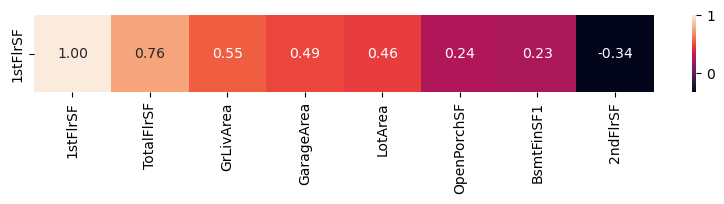

GrLivArea
'TotalFlrSF' (0.87), 

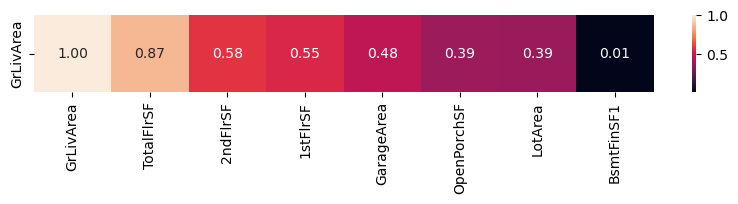

LotArea


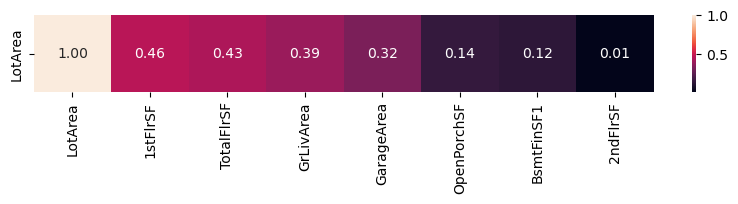

2ndFlrSF


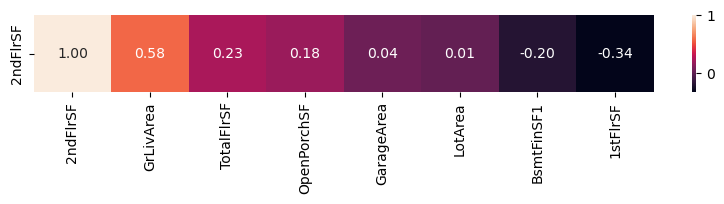

TotalFlrSF
'GrLivArea' (0.87), '1stFlrSF' (0.76), 

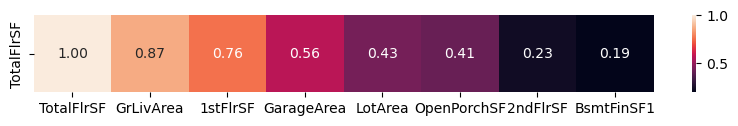

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 변수끼리의 상관 계수
entire_corr = train[numeric_con].corr()
vif_list=[]
total_corr_list=[]
for i in high_vif_columns:
    p=True
    corr_data = train[entire_corr.nlargest(15, i)[i].index]  # .index: Series객체에서 열이름 가져옴
    # 선택된 변수끼리의 상관 계수
    print(i)
    
    selected_corr = corr_data.corr()
    
    corr_list=[]
    # 첫 번째 변수와 그와 상관관계가 높은 변수들의 상관계수 및 변수명 출력
    for col in selected_corr.columns:
        if col != i:
            correlation = selected_corr.loc[i, col]
            if(correlation>=0.7):
                print(f"'{col}' ({correlation:.2f}),", end=" ")
                corr_list.append(col)
    
    if(len(corr_list)>0):
        vif_list.append(i)
        total_corr_list.append(corr_list)
    
    # 첫 번째 변수와 그와 상관관계가 높은 변수들의 상관계수 히트맵 그리기
    figure, ax1 = plt.subplots(nrows=1, ncols=1)
    figure.set_size_inches(10, 1)
    sns.heatmap(selected_corr.iloc[[0], :], annot=True, ax=ax1, fmt='.2f')
    plt.show()


In [183]:
for i, j in zip(vif_list, total_corr_list):
    print(i)
    print(j)

1stFlrSF
['TotalFlrSF']
GrLivArea
['TotalFlrSF']
TotalFlrSF
['GrLivArea', '1stFlrSF']


In [184]:
# 다중공선성있는 특성+그 특성과 관련있는 특성
print(total_corr_list)

[['TotalFlrSF'], ['TotalFlrSF'], ['GrLivArea', '1stFlrSF']]


# 8. PCA

vif가 10 이상인 특성(다중공선성있는 특성)과 상관계수가 0.7이상인 특성들로 PCA 진행

In [185]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

k = 0
# pca로 만든 특성들 저장할 리스트
pca_feature=[]
for i, j in zip(vif_list, total_corr_list):
    selected_feature =[]
    selected_feature.append(vif_list[0])
    for m in j:
            selected_feature.append(m)
    # print(selected_feature)
    selected_data = data[selected_feature]

    # 데이터 스케일링
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(selected_data)

    # PCA 모델 생성
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(scaled_data)

    # PCA 결과를 데이터프레임에 추가
    data[f'{i}_{j[0]}_{k}'] = pca_result
    pca_feature.append(f'{i}_{j[0]}_{k}')

    # PCA 결과 확인
    print(f'{i}_{j[0]}_{k}')
    print("설명 분산", pca.explained_variance_ratio_)
    k += 1


1stFlrSF_TotalFlrSF_0
설명 분산 [0.87677624]
GrLivArea_TotalFlrSF_1
설명 분산 [0.87677624]
TotalFlrSF_GrLivArea_2
설명 분산 [0.80649407]


In [186]:
# pca에 쓰인 모든 컬럼 data에서 drop
selected_feature =[]
for i, j in zip(vif_list, total_corr_list):
    selected_feature.append(vif_list[0])
    for m in j:
            selected_feature.append(m)
drop_list=list(set(selected_feature))
data=data.drop(drop_list, axis=1)

# drop_list에 포함된 특성들 지움
for item in drop_list:
    if item in category_order:
        category_order.remove(item)
    if item in numeric_order:
        numeric_order.remove(item)
    if item in numeric_con:
        numeric_con.remove(item)
    if item in total_encode:
        total_encode.remove(item)

In [187]:
# pca로 만든 컬럼 중 같은 조합인 특성 drop

total_list=[]
for i in pca_feature:
    original_list=[]
    split_string=i.split('_')
    var1=split_string[0]
    var2=split_string[1]
    original_list.append(var1)
    original_list.append(var2)
    total_list.append(set(original_list))
    
unique_sets = set()
duplicates = set()

for s in total_list:
    base = frozenset(s)
    if base in unique_sets:
        duplicates.add(base)
    else:
        unique_sets.add(base)

duplicate_list=[]
print("중복으로 생긴 조합")
for i in duplicates:
    print(list(i))
    duplicate_list.append(list(i))
    

중복으로 생긴 조합
['TotalFlrSF', 'GrLivArea']


In [188]:
for i in pca_feature:
    original_list=[]
    split_string=i.split('_')
    var1=split_string[0]
    var2=split_string[1]
    for j in duplicate_list:
        if(var1==j[0] and var2==j[1]):
            pca_feature.remove(i)

In [189]:
# 최종적으로 생긴 pca 특성 리스트
pca_feature

['1stFlrSF_TotalFlrSF_0', 'GrLivArea_TotalFlrSF_1']

In [190]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = data[numeric_con]
# VIF 계산
vif = pd.DataFrame()
vif['Features'] = numeric_con
vif['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

      Features       VIF
0      LotArea  8.662897
1  OpenPorchSF  2.410913
2   GarageArea  7.187737
3     2ndFlrSF  1.824320
4   BsmtFinSF1  3.098809


# 9. 모델링

1. 원핫인코딩

In [191]:
#원핫인코딩하기 전에 데이터 형변환
for i in total_encode:
    data[i] = data[i].astype(str)

In [192]:
one_hot_encoded=pd.get_dummies(data[total_encode])

2. Min-Max Scaling

In [193]:
print(numeric_con)

['LotArea', 'OpenPorchSF', 'GarageArea', '2ndFlrSF', 'BsmtFinSF1']


In [194]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 선택할 컬럼 리스트 (타겟변수인 SalePrice는 제외)
columns_to_scale = numeric_con

# 선택한 컬럼들에 Min-Max Scaling 적용
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

3. 최종 데이터셋

In [195]:
#원핫인코딩 데이터셋, 연속형 값 데이터셋 결합(타겟변수인 SalePrice도 continous_col에 포함되어있음)
# + pca로 만든 특성들
data=pd.concat([one_hot_encoded,data[numeric_order],data[category_order],data[numeric_con],
                data['SalePrice'],data[pca_feature]], axis=1)

4. train, test set 다시 분할

In [196]:
train=data[:len(train)]
test=data[len(train):]

!!! 최종 제출할 때는 base_X_train, base_y_train으로 훈련시킨거로 test를 예측해서 제출해야함

In [197]:
base_y_train=train['SalePrice']
base_X_train=train.drop('SalePrice', axis=1)

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(base_X_train, base_y_train, test_size=0.2, shuffle=True, random_state=42)

--------

# 10. 최종 모델 (XGBoost)

CV Fold 1 - Score: 0.0821, MSE: 0.0148, RMSE: 0.1216
CV Fold 2 - Score: 0.0880, MSE: 0.0162, RMSE: 0.1273
CV Fold 3 - Score: 0.0910, MSE: 0.0193, RMSE: 0.1388
CV Fold 4 - Score: 0.0843, MSE: 0.0140, RMSE: 0.1183
CV Fold 5 - Score: 0.0796, MSE: 0.0125, RMSE: 0.1119
RMSE 평균: 0.12356719970568905
RMSE 표준편차: 0.009095537652688838


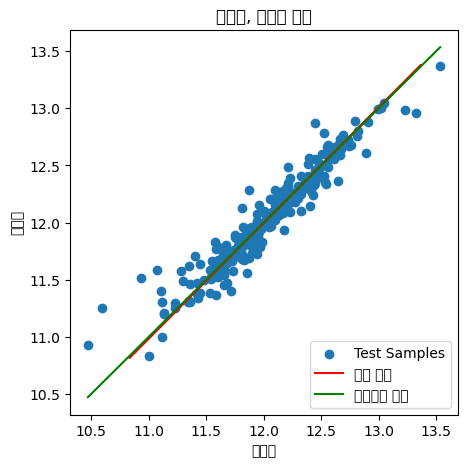

In [199]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost 모델 (예측 성능 확인을 위해 train set에서 test set까지 분할한 이후의 데이터셋 사용)
model_XGBoost = xgb.XGBRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_XGBoost.fit(X_train, y_train)
model_val(model_XGBoost, X_train, y_train)
visualize_model_predictions(model_XGBoost, X_test, y_test)

In [200]:
# 실제로는 전체 train set으로 모델 훈련 
last_model_XGBoost = xgb.XGBRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_XGBoost.fit(base_X_train, base_y_train)
model_val(model_XGBoost, base_X_train, base_y_train)

CV Fold 1 - Score: 0.0797, MSE: 0.0122, RMSE: 0.1104
CV Fold 2 - Score: 0.0885, MSE: 0.0167, RMSE: 0.1291
CV Fold 3 - Score: 0.0845, MSE: 0.0161, RMSE: 0.1269
CV Fold 4 - Score: 0.0791, MSE: 0.0130, RMSE: 0.1141
CV Fold 5 - Score: 0.0862, MSE: 0.0162, RMSE: 0.1271
RMSE 평균: 0.12152931845064938
RMSE 표준편차: 0.007706808608796276


# 11. 최종 제출 파일 생성 

In [201]:
submission_test=test.drop('SalePrice',axis=1)
submission_y_pred = model_XGBoost.predict(submission_test)
submission = pd.DataFrame()
submission['Id'] = test.index
submission['SalePrice'] = np.expm1(submission_y_pred)
# submission.to_csv("submit.csv", index=False)